# A guide to paticle motion estimation with `pyusel-dispest`

In [2]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

# Define the imaging setup and dispacement field

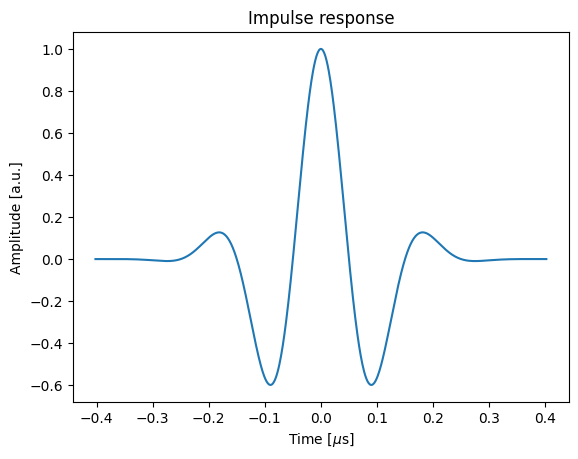

In [3]:
# define the imaging PSF
bw=80/100
f = 5E6
c = 1540
fs = 1E9

tc = sig.gausspulse('cutoff', bw=bw, tpr=-80, fc=f)
Ntc = np.ceil(tc*fs)
timp = (np.arange(2*Ntc+1)-Ntc)/fs
imp = sig.gausspulse(t=timp, bw=bw, tpr=-80, fc=f)

plt.figure()
plt.plot(1E6*timp, imp)
plt.xlabel("Time [$\\mu$s]")
plt.ylabel("Amplitude [a.u.]")
plt.title("Impulse response")
plt.show()

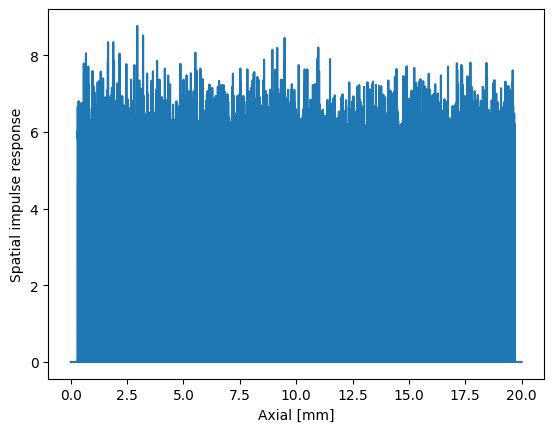

In [4]:
# define the scatterer field
dx = c/(2*fs)
x = np.arange(0, 20E-3, dx)
rng = np.random.default_rng()

x0 = rng.uniform(dx*Ntc, dx*(len(x)-Ntc), 10000)
ix0 = np.round(x0/dx).astype(int)
a0 = rng.normal(5, 1, 10000)
a0[a0 <= 0.1] = 0.1
scat = np.zeros(len(x))
scat[ix0] += a0

plt.figure()
plt.plot(1E3*x, scat)
plt.xlabel("Axial [mm]")
plt.ylabel("Spatial impulse response")
plt.show()

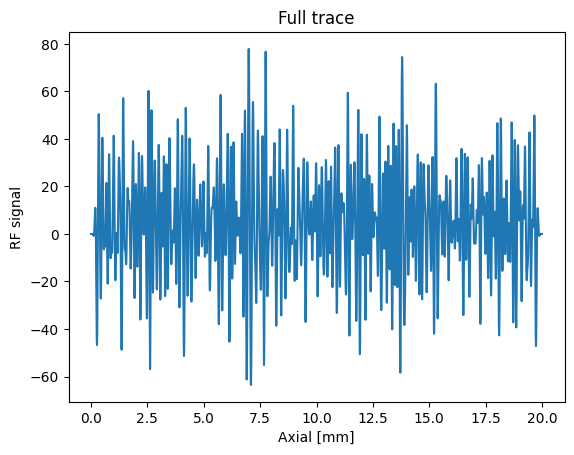

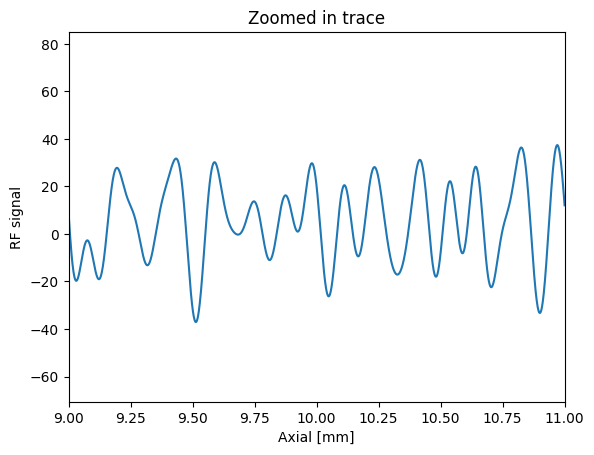

In [5]:
trace0 = np.convolve(imp, scat, mode='same')

plt.figure()
plt.plot(1E3*x, trace0)
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Full trace")
plt.show()

plt.figure()
plt.plot(1E3*x, trace0)
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Zoomed in trace")
plt.xlim(9, 11)
plt.show()

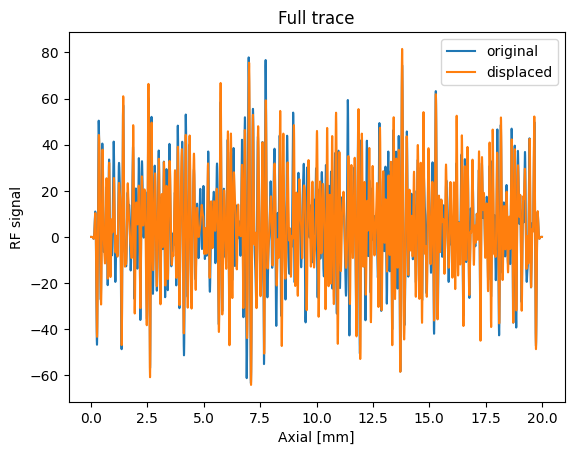

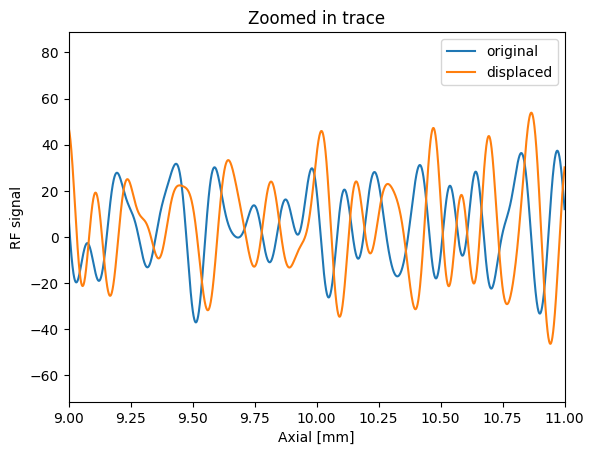

In [6]:
# define the displacement field
f_disp = lambda x, mag=50E-6: mag*np.exp(-(x-10E-3)**2/(2E-3**2))

ix0 = np.round((x0+f_disp(x0))/dx).astype(int)
a0 = rng.normal(5, 1, 10000)
a0[a0 <= 0.1] = 0.1
scat = np.zeros(len(x))
scat[ix0] += a0

trace1 = np.convolve(imp, scat, mode='same')

plt.figure()
plt.plot(1E3*x, trace0, label='original')
plt.plot(1E3*x, trace1, label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Full trace")
plt.show()

plt.figure()
plt.plot(1E3*x, trace0, label='original')
plt.plot(1E3*x, trace1, label='displaced')
plt.legend()
plt.xlabel("Axial [mm]")
plt.ylabel("RF signal")
plt.title("Zoomed in trace")
plt.xlim(9, 11)
plt.show()

## Displacement estimation using Kasai algorithm

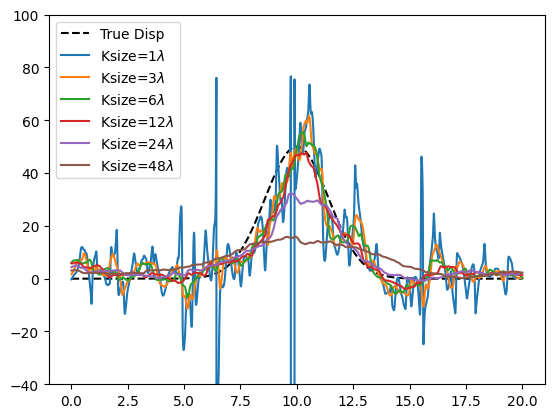

In [7]:
import dispest as de

# convert rfsignal to IQ to get phase information
IQ0 = sig.hilbert(trace0).reshape((-1,1))
IQ1 = sig.hilbert(trace1).reshape((-1,1))
IQ = np.concatenate((IQ0, IQ1), axis=1)
I = np.real(IQ)
Q = np.imag(IQ)

plt.figure()
plt.plot(1E3*x, 1E6*f_disp(x), color='k', linestyle='--', label='True Disp')

# calculate displacement with different kernel lengths
disps = []
for lam in [1, 3, 6, 12, 24, 48]:
    ksize = int(np.round(lam*fs/f))
    disp = de.calc_kasai(I, Q, taxis=1, fd=f, c=c, ksize=ksize, kaxis=0)
    plt.plot(1E3*x, disp, linestyle='-', label=  f"Ksize={lam}" + '$\\lambda $')

plt.legend()
plt.ylim(-40, 100)
plt.show()


# Normalized Cross correlation

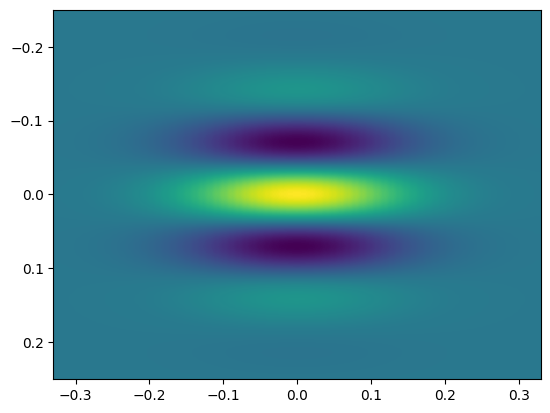

In [46]:
# define the imaging PSF
bw=70/100
f = 5E6
c = 1540
fs = 1E9
kx = 1E5 # [1/m]

# temporal extent
tc = sig.gausspulse('cutoff', bw=bw, tpr=-40, fc=f)
Ntc = int(np.ceil(tc*fs))
timp = (np.arange(2*Ntc+1)-Ntc)/fs
imp_t = sig.gausspulse(t=timp, bw=bw, tpr=-40, fc=f)

# make spatial extent laterally
xc = np.sqrt(-0.15E-3**2 * np.log(0.01))
Nxc = int(np.ceil(xc*kx))
ximp = (np.arange(2*Nxc+1)-Nxc)/kx
imp_x = np.exp(-(ximp/0.15E-3)**2)

psf = imp_t[:,np.newaxis] * imp_x[np.newaxis,:]
ext_imp = [1E3*ximp[0], 1E3*ximp[-1], 1E3*c*timp[-1]/2, 1E3*c*timp[0]/2]
plt.figure()
plt.imshow(psf, extent = ext_imp)
plt.gca().set_aspect("equal")
plt.show()

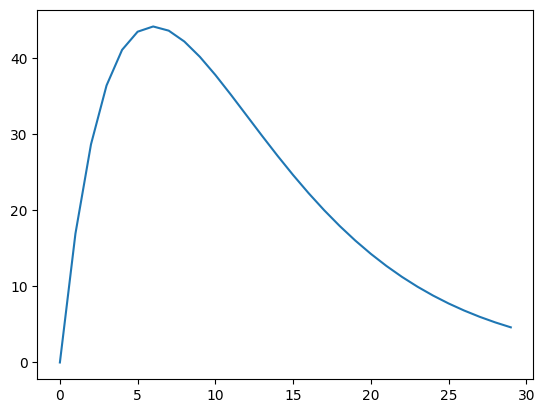

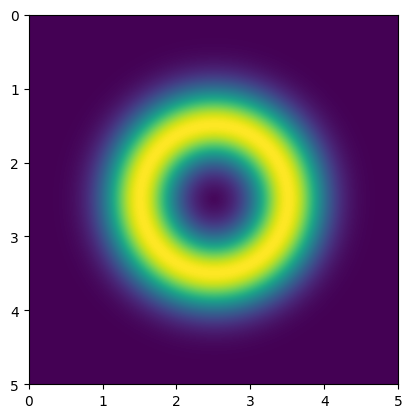

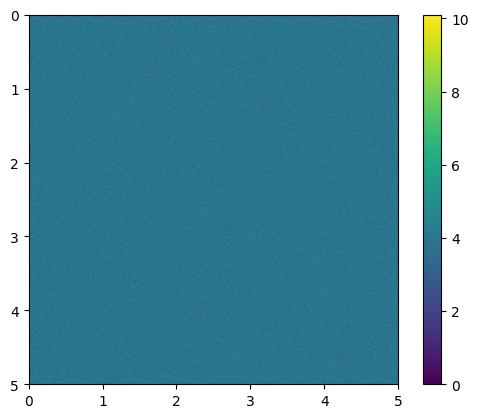

(30, 650, 200)
(30, 6494, 1000)


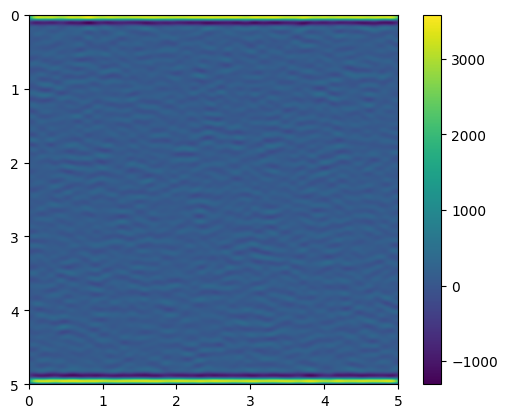

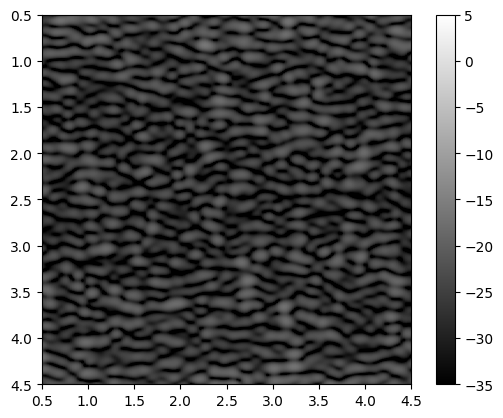

Speckle SNR: 2.0539361149043542


In [78]:
# define the scatterer field
dlat = 1/(2*kx)
dax = c/(2*fs)
nscat = int(10E6)
nT = 30

axial = np.arange(0, 5E-3, dax)
lateral = np.arange(0, 5E-3, dlat)
rng = np.random.default_rng()

lat0 = rng.uniform(0, lateral[-1], nscat)
ax0 = rng.uniform(0, axial[-1], nscat)
scat = np.zeros((nT, len(axial), len(lateral)))

a0 = rng.normal(5, 1, nscat)
a0[a0 <= 0.01] = 0.01

# make temporal displacement trace
disp_scalar = 20E-6*np.arange(nT)*np.exp(-5*np.arange(nT)/nT)

plt.figure()
plt.plot(1E6*disp_scalar)
plt.show()

# make spatial dispalcment trace
def f_disp_2D(axial, lateral, mag=1):
    r = np.sqrt((axial - 2.5E-3)**2 + (lateral - 2.5E-3)**2)
    return mag*np.exp(-(r-1E-3)**2/(0.5E-3**2))

dvec = f_disp_2D(ax0, lat0)
dfield = f_disp_2D(axial[:,np.newaxis], lateral[np.newaxis,:])

plt.figure()
plt.imshow(dfield, extent=[0,5,5,0])
plt.show()


ilat0 = np.round(lat0/dlat).astype(int)

for iT, mag in enumerate(disp_scalar):
    iax0 = np.round((ax0+mag*dvec)/dax).astype(int)

    scat[iT, iax0, ilat0] += a0

plt.figure()
plt.imshow(scat[0,:,:], extent=[0, 5, 5, 0])
plt.colorbar()
plt.show()

rf = sig.fftconvolve(scat, psf[np.newaxis,:,:], mode='same', axes=(1,2))[:,::10,::5]

print(rf.shape)
print(scat.shape)

plt.figure()
plt.imshow(rf[6,:,:], extent=[0, 5, 5, 0])
plt.colorbar()
plt.show()

env = np.abs(sig.hilbert(rf[0,:,:], axis=0))
logged = 20*np.log10(env/np.percentile(env, 99))

plt.figure()
plt.imshow(logged, extent=[0, 5, 5, 0], vmin=-35, vmax=5, cmap='gray')
plt.ylim(4.5, 0.5)
plt.xlim(0.5, 4.5)
plt.colorbar()
plt.show()

print("Speckle SNR:", np.mean(env[100:-100,50:-50])/np.std(env[100:-100,50:-50]))

In [85]:
import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARNING)

In [113]:
class CalcNXCorr():
    """A callabel class that calculates the normalized cross correlation on the input data"""
    def __init__(self, shape, kaxis:int, taxis:int, klen:float|int, kstep:float|int, kmin:float|int, kmax:float|int, spm:float|int, fs:float|None=None, c:float|None=None, progressive:bool=True):
        """Make a callable class to calcualte the normalized cross correlation

        Calculates the normalized cross corellation using speed ups from numpy. Calcualtes shift signal-pair wise - working on tensor version

        # Parameters:
        `shape`: the shape of the data on which nxcorr is being calcualted
        `kaxis`: the axis the kernel is places on
        `taxis`: the temporal axis signals are being compared across
        `klen`: timespan (s) of the correlation kernel. If fs is `None`, klen is assumed to be an integer
        `kstep`: timespan (s) to step the refernce kernel. If fs is `None`, kstep is assumed to be an integer
        `spm`: timespan (s) to search from the reference point. If fs is `None`, spm is assumed to be an integer
        `fs`: sampling frequency in Hz. If not given, indical shifts are returned
        `c`: speed of spound in meters/second. If not given, either temporal or indical shifts are returned (depending on fs)
        `progressive`: whether or not to use progressive referencing

        # Returns
        ...an instance of a `CalcNXCorr` object that can called to calculate the nxcorr of data that matches the given specifications
        """

        # Copy and extract keys
        self.__shape = shape
        self.__kaxis = kaxis
        self.__Ns = shape[kaxis]
        self.__taxis = taxis
        self.__Nt = shape[taxis]
        self.__progressive = progressive

        # determine the output scaling and units
        if fs is None:
            logger.info("fs is None, shift reurned in indices")
            self.__scale: float = 1.0
            self.__kmin:int = int(kmin)
            self.__kmax:int = int(kmax)
            self.__klen : int = int(klen)
            self.__kstep : int = int(kstep)
            self.__spm : int = int(spm)
            logger.info(f"klen={klen} indices, kstep={kstep} indices, smp={spm} indices")
        else:
            self.__kmin:int = int(np.ceil(kmin*fs))
            self.__kmax:int = int(np.ceil(kmin*fs))
            self.__klen : int = int(np.ceil(klen*fs))
            self.__kstep : int = int(np.ceil(kstep*fs))
            self.__spm : int = int(np.ceil(spm*fs))

            if c is None:
                logger.info(f"fs is {fs:0.01f} and c is None, converting shift to time in seconds")
                self.__scale : float = 1/fs
                logger.info(f"kmin={self.__kmin} indices and {self.__kmin/fs:0.03e} seconds") 
                logger.info(f"kmax={self.__kmax} indices and {self.__kmax/fs:0.03e} seconds") 
                logger.info(f"klen={self.__klen} indices and {self.__klen/fs:0.03e} seconds") 
                logger.info(f"kstep={self.__kstep} indices and {self.__kstep/fs:0.03e} seconds")
                logger.info(f"spm={self.__spm} indices and {self.__spm/fs:0.03e} seconds")
            else:
                logger.info(f"fs is {fs:0.01f} and c is {c}, converting shift to space in meters")
                self.__scale : float = c/(2*fs)
                logger.info(f"kmin={self.__kmin} indices and {self.__kmin*c/(2*fs):0.03e} meters") 
                logger.info(f"kmax={self.__kmax} indices and {self.__kmax*c/(2*fs):0.03e} meters") 
                logger.info(f"klen={self.__klen} indices and {self.__klen*c/(2*fs):0.03e} meters") 
                logger.info(f"kstep={self.__kstep} indices and {self.__kstep*c/(2*fs):0.03e} meters") 
                logger.info(f"spm={self.__spm} indices and {self.__spm*c/(2*fs):0.03e} meters") 

        self.__get_xcorr_pair_inds()

    def __get_xcorr_pair_inds(self):
        """Calcualtes index lookup tables for a mu subtracted normalized cross correlation
        
        # Parameters
        `__Ns`: length of signals
        `__kstart`: starting index of reference signal
        `__klen`: length of the kernel to include
        `__kstep: how many indices to step reference kernel
        `__spm`: how many indices on either side of reference to search

        # Returns
        `iref`: a (M by `__klen`) matrix containing selected indices for reference kernels in s1
        `iser`: an (N by `__klen`) matrix containing selected indices for search kernels in s2
        `ser2ref`: a slicing object to convert already selected search data to reference data
        """

        #__Ns:int, __kmin:int, __kmax:int, __klen:int, __kstep:int, __spm:int
        __Ns:int = self.__Ns
        __kmin:int = self.__kmin
        __kmax:int = self.__kmax
        __klen:int = self.__klen
        __kstep:int = self.__kstep
        __spm:int = self.__spm

        # find the starting indices of each reference kernel
        __kmin = int(np.max([0, __kmin]))
        __kmax = int(np.min([__Ns-__klen, __kmax]))
        __ref0s = np.arange(__kmin, __kmax, __kstep, dtype=np.intp)
        for name, num in zip(['ns','kmin','kmax','klen','kstep','spm'],[__Ns,__kmin,__kmax,__klen,__kstep,__spm]): print(name, num)

        # find the needed range of search kernels +/- spm areound reference
        __isermin = int(np.max([__kmin-__spm, 0]))
        __isermax = int(np.min([__Ns, __ref0s[-1]+__spm-__klen]))
        __ser0s = np.arange(__isermin, __isermax, dtype=np.intp)

        # make indical kernel
        __kern = np.arange(__klen, dtype=int)

        # broadcast to output selected data as matrices
        iref = __ref0s[:,np.newaxis] + __kern[np.newaxis,:]
        iser = __ser0s[:,np.newaxis] + __kern[np.newaxis,:]
        
        # make a slicing object to get all rows of search to be used in next ref
        __is2r = np.where(__ser0s == __kmin)[0]
        __is2rmax = __is2r + (len(__ref0s) - 1) * __klen + 1
        ser2ref = slice(__is2r, __is2rmax, __klen)

        if self.__kmin != __kmin: logger.info(f"Kmin updated to be {__kmin}")
        self.__kmin = __kmin

        if self.__kmax != __kmax: logger.info(f"Kmax updated to be {__kmax}")
        self.__kmax = __kmax

        self.__iref = iref
        self.__iser = iser
        self.__ser2ref = ser2ref

    def __calc_pairs_prog_itr__(self, rf):
        """Calcualte nxcorr using progressive reference"""
        itrshape = [dim if (ii != self.__kaxis) and (ii != self.__taxis) else 1 for ii, dim in enumerate(self.__shape) ]

        # iterate axross all other dimensions in the tensor
        for ii in range(np.prod(itrshape)):
            coords = [*np.unravel_index(ii, itrshape)]

            # get reference data
            coords[self.__kaxis] = self.__iref
            coords[self.__taxis] = slice(self.__Nt-1)
            ref = rf[*coords]

            # get search data
            coords[self.__kaxis] = self.__iser
            coords[self.__taxis] = slice(1, self.__Nt)
            search = rf[*coords]

            ref = ref - np.mean(ref, axis=-1)[..., np.newaxis]
            ref = ref/(np.std(ref, axis=-1)[:,:,np.newaxis])

            search = search - np.mean(search, axis=-1)[..., np.newaxis]
            search = search/(np.std(search, axis=-1)[...,np.newaxis])

            cross = np.sum(ref[:,:,np.newaxis,:] * search[:,np.newaxis,:,:], axis=-1)
            print(cross.shape, ref.shape, search.shape)
            break



    def __calc_pairs_fixed_itr__(self, rf):
        """Calcualte nxcorr using fixed reference"""
        raise NotImplementedError("Fixed reference is not implemented yet") 
                

    def __call__(self, rf, unit_scale_factor:float=1):
        """Put a velocity tensor that matches the specifications here"""
        
        for vdim, sdim in zip(rf.shape, self.__shape): 
            if vdim != sdim:
                raise TypeError("rf data must be the same shape as the input")
        
        if self.__progressive: shift = self.__calc_pairs_prog_itr__(rf)
        else: shift = self.__calc_pairs_prog_itr__(rf)

In [114]:
nxcor = CalcNXCorr(rf.shape, kaxis=1, taxis=0, klen=20, kstep=2, kmin=100, kmax=500, spm=50)
nxcor(rf)

ns 650
kmin 100
kmax 500
klen 20
kstep 2
spm 50
(29, 200, 200) (29, 200, 20) (29, 478, 20)
